In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, classification_report, confusion_matrix,
    roc_curve, auc
)
from wordcloud import WordCloud
import xgboost as xgb

# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("matches.csv")   # apna dataset ka path lagao

X = df.drop("result", axis=1)
y = df["result"]

# Handle categorical (convert to category codes)
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category").cat.codes

X = X.fillna(-999)

# ==============================
# 2. Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 3. Train XGBoost
# ==============================
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# ==============================
# 4. Predictions & Metrics
# ==============================
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)

print("✅ Accuracy :", accuracy_score(y_test, y_pred))
print("✅ Precision:", precision_score(y_test, y_pred, average="weighted"))
print("✅ Recall   :", recall_score(y_test, y_pred, average="weighted"))
print("✅ F1 Score :", f1_score(y_test, y_pred, average="weighted"))
print("✅ MCC      :", matthews_corrcoef(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# ==============================
# 5. Advance Visualizations (10)
# ==============================

# 1️⃣ Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2️⃣ Normalized Confusion Matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3️⃣ Feature Importance
xgb.plot_importance(xgb_clf, importance_type="weight", height=0.5, max_num_features=15)
plt.title("Feature Importances (XGBoost)")
plt.show()

# 4️⃣ Classification Report Heatmap
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="viridis")
plt.title("Classification Report Heatmap")
plt.show()

# 5️⃣ WordCloud from Predictions
text = " ".join(map(str, y_pred.flatten()))
wc = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Predictions")
plt.show()

# 6️⃣ ROC Curve (One-vs-Rest)
plt.figure(figsize=(8,6))
for i in range(y_prob.shape[1]):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr, tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.show()

# 7️⃣ Prediction Distribution
plt.figure(figsize=(8,6))
sns.countplot(x=y_pred, palette="Set2")
plt.title("Prediction Distribution")
plt.show()

# 8️⃣ Actual vs Predicted Comparison
plt.figure(figsize=(10,6))
sns.histplot(y_test, color="blue", alpha=0.5, label="Actual")
sns.histplot(y_pred, color="red", alpha=0.5, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Distribution")
plt.show()

# 9️⃣ MCC Trend by Class
mcc_per_class = []
for i in np.unique(y_test):
    y_true_bin = (y_test == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    mcc_per_class.append(matthews_corrcoef(y_true_bin, y_pred_bin))
plt.figure(figsize=(8,6))
sns.barplot(x=np.unique(y_test), y=mcc_per_class, palette="cool")
plt.title("MCC per Class")
plt.xlabel("Class")
plt.ylabel("MCC Score")
plt.show()

# 🔟 Accuracy by Class
acc_per_class = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8,6))
sns.barplot(x=np.unique(y_test), y=acc_per_class, palette="magma")
plt.title("Accuracy per Class")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()


ModuleNotFoundError: No module named 'xgboost'

In [2]:
from sklearn.preprocessing import label_binarize

# ROC Curve (Multi-class One-vs-Rest)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.show()


NameError: name 'y_test' is not defined

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from wordcloud import WordCloud
import xgboost as xgb

# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("matches.csv")   # apna dataset ka path lagao

X = df.drop("result", axis=1)
y = df["result"]

# Handle categorical (convert to category codes)
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category").cat.codes

X = X.fillna(-999)

# ==============================
# 2. Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 3. Train XGBoost
# ==============================
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# ==============================
# 4. Predictions & Metrics
# ==============================
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)

print("✅ Accuracy :", accuracy_score(y_test, y_pred))
print("✅ Precision:", precision_score(y_test, y_pred, average="weighted"))
print("✅ Recall   :", recall_score(y_test, y_pred, average="weighted"))
print("✅ F1 Score :", f1_score(y_test, y_pred, average="weighted"))
print("✅ MCC      :", matthews_corrcoef(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# ==============================
# 5. Advance Visualizations (10)
# ==============================

# 1️⃣ Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2️⃣ Normalized Confusion Matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3️⃣ Feature Importance
xgb.plot_importance(xgb_clf, importance_type="weight", height=0.5, max_num_features=15)
plt.title("Feature Importances (XGBoost)")
plt.show()

# 4️⃣ Classification Report Heatmap
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="viridis")
plt.title("Classification Report Heatmap")
plt.show()

# 5️⃣ WordCloud from Predictions
text = " ".join(map(str, y_pred.flatten()))
wc = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Predictions")
plt.show()

# 6️⃣ ROC Curve (Multi-class One-vs-Rest)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.show()

# 7️⃣ Prediction Distribution
plt.figure(figsize=(8,6))
sns.countplot(x=y_pred, palette="Set2")
plt.title("Prediction Distribution")
plt.show()

# 8️⃣ Actual vs Predicted Comparison
plt.figure(figsize=(10,6))
sns.histplot(y_test, color="blue", alpha=0.5, label="Actual")
sns.histplot(y_pred, color="red", alpha=0.5, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Distribution")
plt.show()

# 9️⃣ MCC Trend by Class
mcc_per_class = []
for i in classes:
    y_true_bin = (y_test == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    mcc_per_class.append(matthews_corrcoef(y_true_bin, y_pred_bin))

plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=mcc_per_class, palette="cool")
plt.title("MCC per Class")
plt.xlabel("Class")
plt.ylabel("MCC Score")
plt.show()

# 🔟 Accuracy by Class
acc_per_class = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=acc_per_class, palette="magma")
plt.title("Accuracy per Class")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['no result' 'runs' 'tie' 'wickets']

In [4]:
!pip install xgboost



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 1.4 MB/s eta 0:00:41
    --------------------------------------- 0.8/56.8 MB 1.5 MB/s eta 0:00:39
    --------------------------------------- 1.3/56.8 MB 1.5 MB/s eta 0:00:39
   - -------------------------------------- 1.6/56.8 MB 1.5 MB/s eta 0:00:38
   - -------------------------------------- 1.8/56.8 MB 1.4 MB/s eta 0:00:39
   - -------------------------------------- 2.1/56.8 MB 1.5 MB/s eta 0:00:37
   - -------------------------------------- 2.6/56.8 MB 1.6 MB/s eta 0:00:35
   -- ------------------------------------- 3.1/56.8 MB 1.7 MB/s eta 0:00:33
   -- ------------------------------------- 3.7/56.8 MB 1.8 MB/s eta 0:00:30
   -- ------------------------------------- 4.2/56.8 MB 1.8 MB/s eta 0:00:29
   --- ------------

In [6]:
import xgboost as xgb
print("XGBoost imported successfully ✅")


XGBoost imported successfully ✅


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from wordcloud import WordCloud
import xgboost as xgb

# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("matches.csv")   # <-- update with your dataset

X = df.drop("result", axis=1)
y = df["result"]

# Handle categorical (convert to category codes)
for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category").cat.codes

X = X.fillna(-999)

# ==============================
# 2. Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 3. Train XGBoost
# ==============================
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# ==============================
# 4. Predictions & Metrics
# ==============================
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)

print("✅ Accuracy :", accuracy_score(y_test, y_pred))
print("✅ Precision:", precision_score(y_test, y_pred, average="weighted"))
print("✅ Recall   :", recall_score(y_test, y_pred, average="weighted"))
print("✅ F1 Score :", f1_score(y_test, y_pred, average="weighted"))
print("✅ MCC      :", matthews_corrcoef(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)

# ==============================
# 5. Advance Visualizations (10)
# ==============================

# 1️⃣ Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2️⃣ Normalized Confusion Matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3️⃣ Feature Importance
xgb.plot_importance(xgb_clf, importance_type="weight", height=0.5, max_num_features=15)
plt.title("Feature Importances (XGBoost)")
plt.show()

# 4️⃣ Classification Report Heatmap
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="viridis")
plt.title("Classification Report Heatmap")
plt.show()

# 5️⃣ WordCloud from Predictions
text = " ".join(map(str, y_pred.flatten()))
wc = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Predictions")
plt.show()

# 6️⃣ ROC Curve (Multi-class One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.show()

# 7️⃣ Prediction Distribution
plt.figure(figsize=(8,6))
sns.countplot(x=y_pred, palette="Set2")
plt.title("Prediction Distribution")
plt.show()

# 8️⃣ Actual vs Predicted Comparison
plt.figure(figsize=(10,6))
sns.histplot(y_test, color="blue", alpha=0.5, label="Actual")
sns.histplot(y_pred, color="red", alpha=0.5, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Distribution")
plt.show()

# 9️⃣ MCC Trend by Class
mcc_per_class = []
for i in classes:
    y_true_bin = (y_test == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    mcc_per_class.append(matthews_corrcoef(y_true_bin, y_pred_bin))

plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=mcc_per_class, palette="cool")
plt.title("MCC per Class")
plt.xlabel("Class")
plt.ylabel("MCC Score")
plt.show()

# 🔟 Accuracy by Class
acc_per_class = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=acc_per_class, palette="magma")
plt.title("Accuracy per Class")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['no result' 'runs' 'tie' 'wickets']

In [8]:
from sklearn.preprocessing import LabelEncoder

# Target column encode karo
le = LabelEncoder()
y = le.fit_transform(df["result"])   # 'runs','tie','wickets' → 0,1,2...

# Dekhne ke liye mapping print karo
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Label mapping: {'no result': np.int64(0), 'runs': np.int64(1), 'tie': np.int64(2), 'wickets': np.int64(3)}


In [9]:
from sklearn.model_selection import train_test_split

X = df.drop("result", axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train, y_train)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:season: object, city: object, date: object, match_type: object, player_of_match: object, venue: object, team1: object, team2: object, toss_winner: object, toss_decision: object, winner: object, super_over: object, method: object, umpire1: object, umpire2: object

In [11]:
y_pred = xgb_clf.predict(X_test)

# Agar original labels chahiye
y_pred_labels = le.inverse_transform(y_pred)


NotFittedError: need to call fit or load_model beforehand

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode target (y)
le = LabelEncoder()
y = le.fit_transform(df["result"])   # "runs", "wickets", etc. ko numeric bana dega

# Drop target
X = df.drop("result", axis=1)

# Encode features (categorical -> numeric)
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Fill NaN
X = X.fillna(-999)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# Predict
y_pred = xgb_clf.predict(X_test)

# Agar original labels chahiye:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)


✅ Accuracy : 0.863013698630137
✅ Precision: 0.874217825131067
✅ Recall   : 0.863013698630137
✅ F1 Score : 0.8608828006088282
✅ MCC      : 0.743510505248938

Classification Report:
               precision    recall  f1-score   support

   no result       1.00      1.00      1.00         1
        runs       0.94      0.75      0.83       100
         tie       1.00      1.00      1.00         3
     wickets       0.81      0.96      0.88       115

    accuracy                           0.86       219
   macro avg       0.94      0.93      0.93       219
weighted avg       0.87      0.86      0.86       219



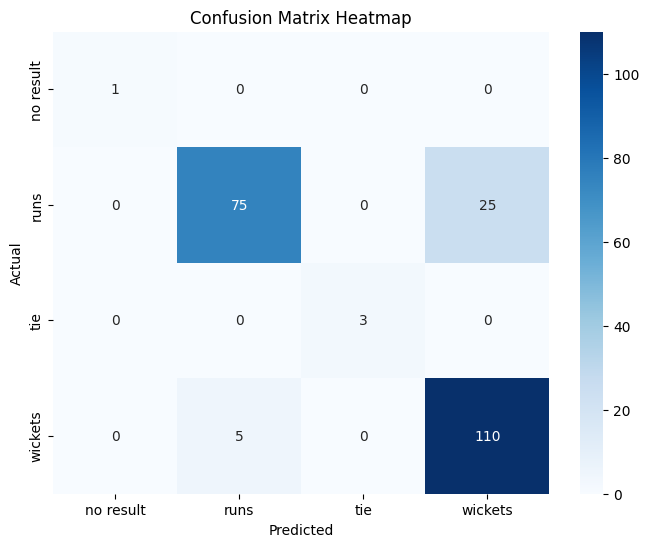

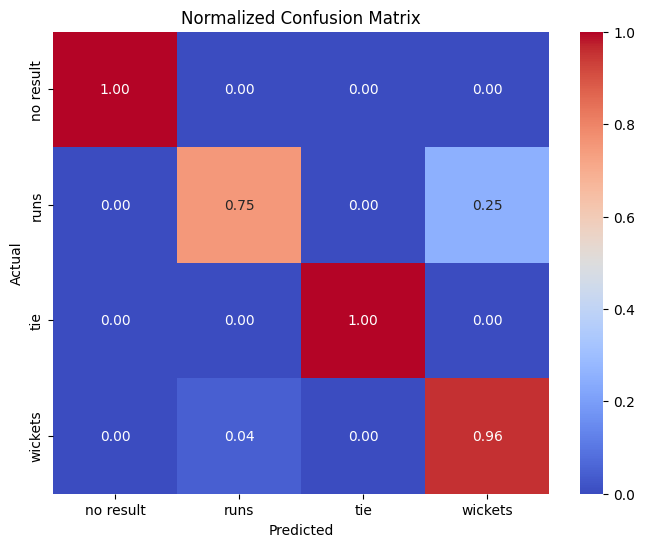

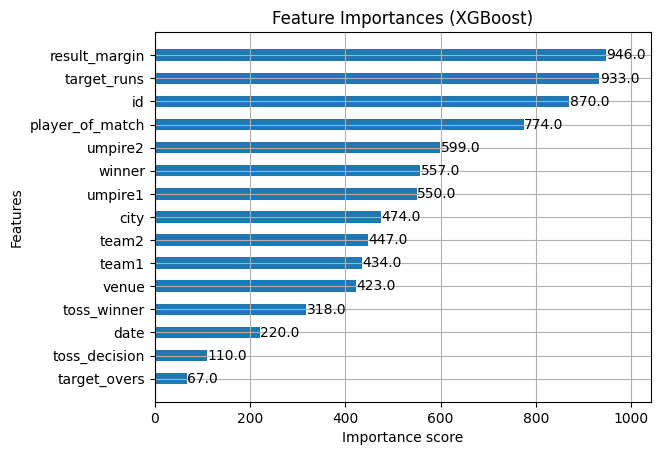

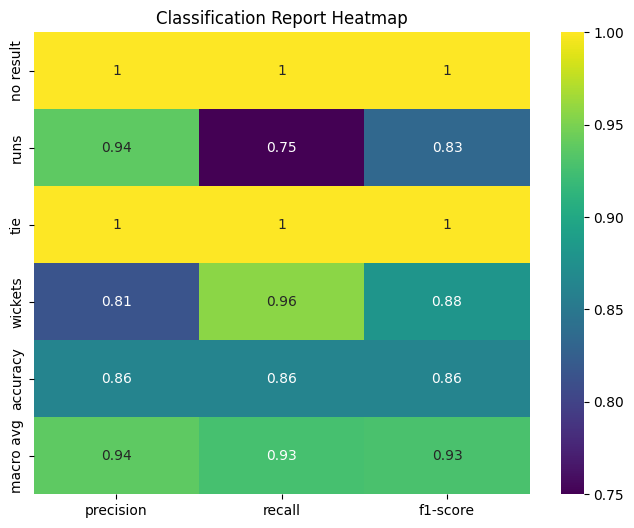

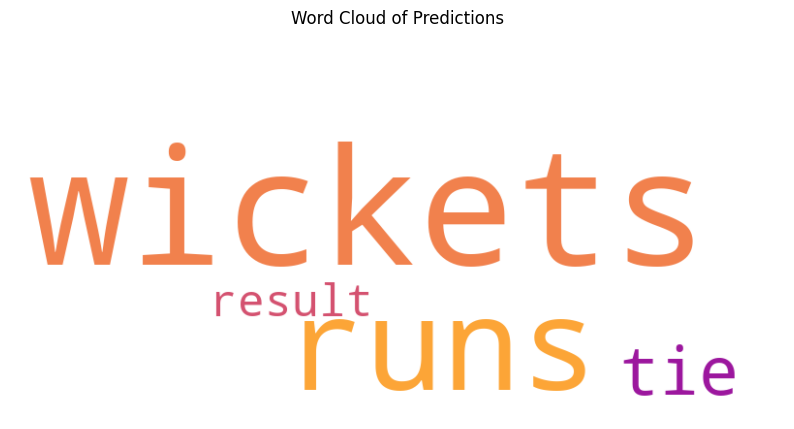

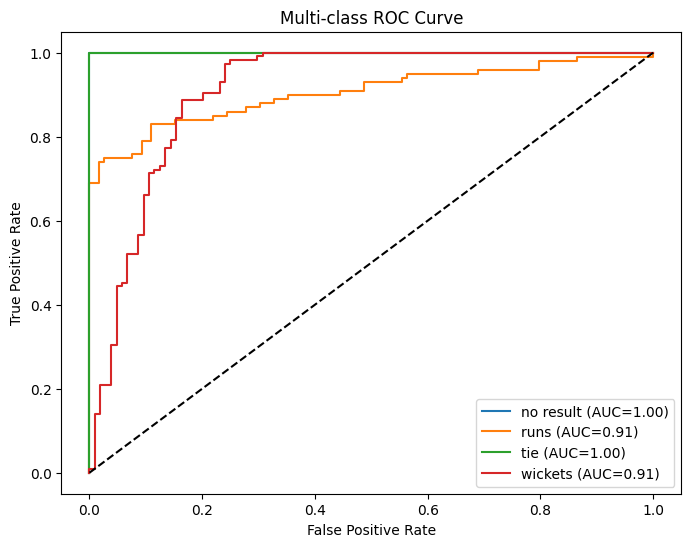

C:\Users\tarun\AppData\Local\Temp\ipykernel_12024\4180079287.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=le.inverse_transform(y_pred), palette="Set2")


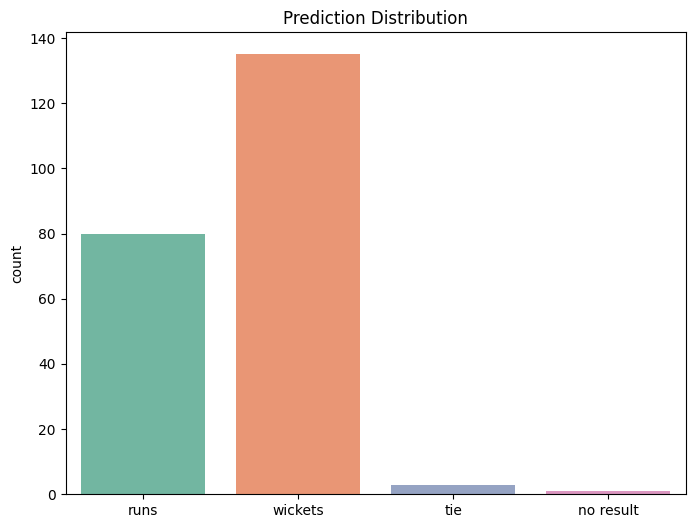

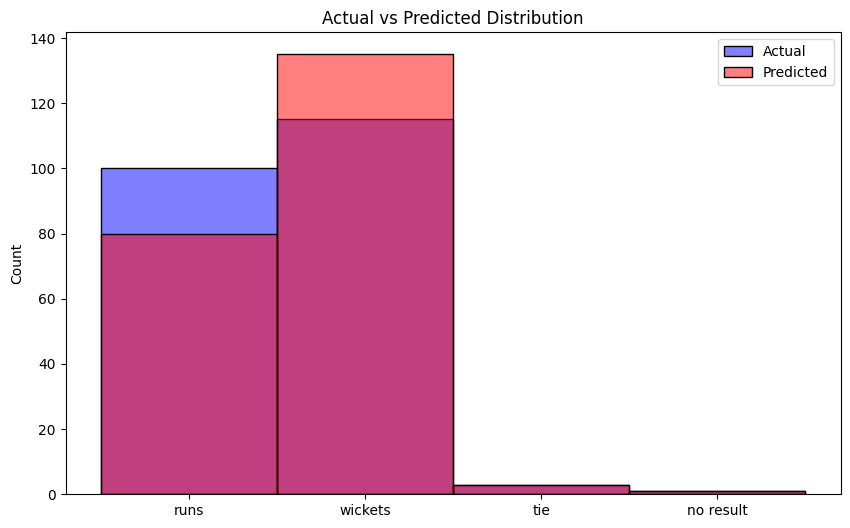

C:\Users\tarun\AppData\Local\Temp\ipykernel_12024\4180079287.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=le.classes_, y=mcc_per_class, palette="cool")


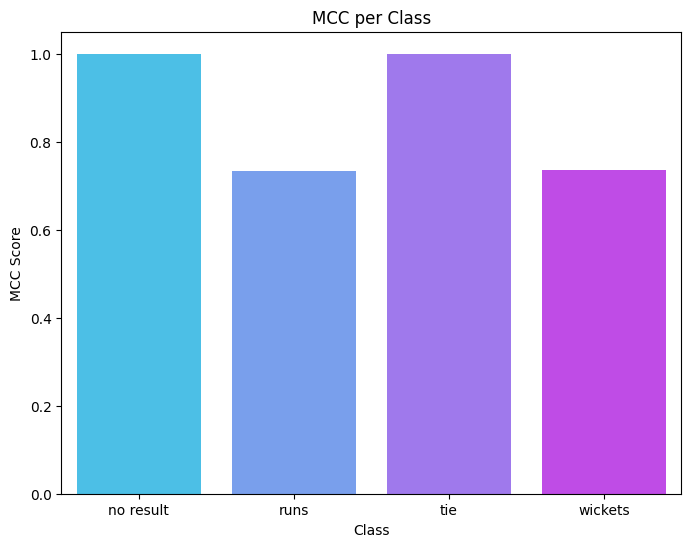

C:\Users\tarun\AppData\Local\Temp\ipykernel_12024\4180079287.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=le.classes_, y=acc_per_class, palette="magma")


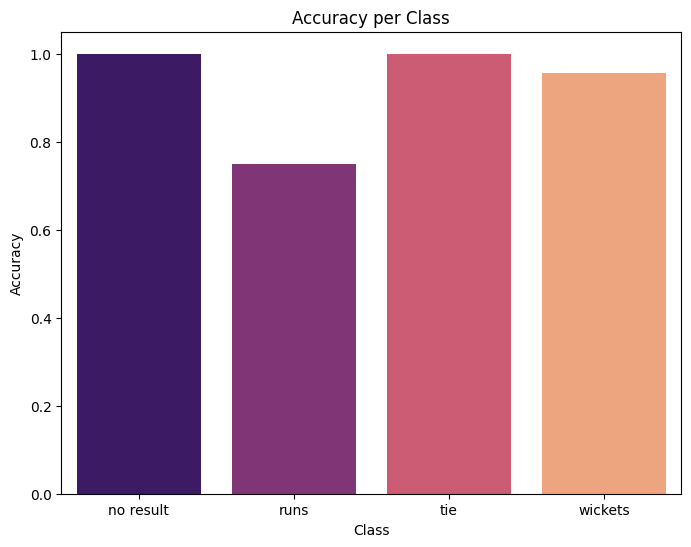

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from wordcloud import WordCloud
import xgboost as xgb

# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("matches.csv")   # apna dataset ka path lagao

# Encode target
le = LabelEncoder()
y = le.fit_transform(df["result"])  # "runs", "wickets", etc -> 0,1,2,3

# Encode features
X = df.drop("result", axis=1)
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))
X = X.fillna(-999)

# ==============================
# 2. Train-Test Split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 3. Train XGBoost
# ==============================
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# ==============================
# 4. Predictions & Metrics
# ==============================
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)

print("✅ Accuracy :", accuracy_score(y_test, y_pred))
print("✅ Precision:", precision_score(y_test, y_pred, average="weighted"))
print("✅ Recall   :", recall_score(y_test, y_pred, average="weighted"))
print("✅ F1 Score :", f1_score(y_test, y_pred, average="weighted"))
print("✅ MCC      :", matthews_corrcoef(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)

# ==============================
# 5. Advance Visualizations (10)
# ==============================

# 1️⃣ Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2️⃣ Normalized Confusion Matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3️⃣ Feature Importance
xgb.plot_importance(xgb_clf, importance_type="weight", height=0.5, max_num_features=15)
plt.title("Feature Importances (XGBoost)")
plt.show()

# 4️⃣ Classification Report Heatmap
report = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(8,6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="viridis")
plt.title("Classification Report Heatmap")
plt.show()

# 5️⃣ WordCloud from Predictions
text = " ".join(le.inverse_transform(y_pred))
wc = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Predictions")
plt.show()

# 6️⃣ ROC Curve (Multi-class One-vs-Rest)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.show()

# 7️⃣ Prediction Distribution
plt.figure(figsize=(8,6))
sns.countplot(x=le.inverse_transform(y_pred), palette="Set2")
plt.title("Prediction Distribution")
plt.show()

# 8️⃣ Actual vs Predicted Comparison
plt.figure(figsize=(10,6))
sns.histplot(le.inverse_transform(y_test), color="blue", alpha=0.5, label="Actual")
sns.histplot(le.inverse_transform(y_pred), color="red", alpha=0.5, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Distribution")
plt.show()

# 9️⃣ MCC Trend by Class
mcc_per_class = []
for i in classes:
    y_true_bin = (y_test == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    mcc_per_class.append(matthews_corrcoef(y_true_bin, y_pred_bin))

plt.figure(figsize=(8,6))
sns.barplot(x=le.classes_, y=mcc_per_class, palette="cool")
plt.title("MCC per Class")
plt.xlabel("Class")
plt.ylabel("MCC Score")
plt.show()

# 🔟 Accuracy by Class
acc_per_class = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8,6))
sns.barplot(x=le.classes_, y=acc_per_class, palette="magma")
plt.title("Accuracy per Class")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()
